In [1]:
import numpy as np
import pandas as pd
import tmm

# imports and setup for tmm
from __future__ import division, print_function, absolute_import

from tmm import (coh_tmm, unpolarized_RT, ellips,
                       position_resolved, find_in_structure_with_inf)

from numpy import pi, linspace, inf, array
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
%matplotlib inline


# "5 * degree" is 5 degrees expressed in radians
# "1.2 / degree" is 1.2 radians expressed in degrees
degree = pi/180

# Import experimental data
In this example we will use just one angle of incidence

In [2]:
# Read the raw data file, skip the first three rows without a header and select the following 51 rows
raw_data = pd.read_csv('25 nm of SiO2.dat', sep = '\t', skiprows=3 , nrows=51 , header=None)
#Rename the columns of the raw data frame into relevant features
raw_data.columns = ['lambda_vac', 'th_0', 'psi_exp', 'delta_exp', 'psi_exp_sigma', 'delta_exp_sigma']

# Import Silicon refractive index
Monocrystalline Silicon refractive index data is imported from a tabulated list

In [3]:
from materials import (Si_nk_fn)

# Create a function-based refractive index for SiO$_2$

#In this case since SiO2 is a transparent material, the index of refraction n and absorption coefficient k can be described by a slowly varying function of wavelength, $\lambda$ (in um), and an exponential absorption tail, respectively. This model is called a Cauchy layer.

\begin{equation}
n(\lambda)=A+\frac{B}{\lambda^2}+\frac{C}{\lambda^4}
\tag{1}
\end{equation}
\begin{equation}
k(\lambda)=\alpha e^{\beta\left[1.24\mu m\left(\frac{1}{\lambda}-\frac{1}{\gamma}\right)\right]}
\tag{2}
\end{equation}

The parameters of this model are A, B, C, extintion coefficient amplitude $\alpha$, exponent factor $\beta$ and band edge $\gamma$ (in $\mu m$).


In [4]:
import math

def nk_cauchy(A,B,C,alpha, beta, gamma, lambda_vac):
    
#the values are entered in nm
    
    #convert to um
    lambda_vac_um=lambda_vac/1000
    gamma_um=gamma/1000
    
    #calculate n
    n_cauchy=A+B/(lambda_vac_um)**2+C/(lambda_vac_um)**4
    
    #calculate k
    k_cauchy=alpha*math.exp(beta*(1.24*((1/lambda_vac_um)-(1/gamma_um))))
    
    #return complex refractive index
    return complex(n_cauchy, k_cauchy);

# Define MSE
The mean squared error (MSE) is defined as a function of the thickness and parameters $A$ and $B$ of the Cauchy layer, which is modeled on top of a silicon substrate simulating an air/SiO$_2$/Si material.
Notice that we set $\alpha=0$ so that $k=0$ (see Eq.(2)), this is because SiO$_2$ is known to behave as a fully transparent material, in this case $\beta$ and $\gamma$ will not affect the model. For the remaining parameters $C=0$ and a sufficiently small value for $B$ are common assumptions for non absorbing films.  

In [5]:
def MSE(params):
    
    #set the known parameters. 
    alpha=0
    beta=1.5
    gamma=400 
    B=0.01
    C=0
    thickness,A = params
    
    #set number of layers and thickness
    d_list = [inf,thickness,inf] #in nm
    
    #set wavelength range
    lambda_list = linspace(300,800,51) #in nm
    
    # calculate psi and delta from the model 
    psi_mod=[]
    delta_mod=[]
    for lambda_vac in lambda_list:
                n_list = [1,nk_cauchy(A,B,C,alpha, beta, gamma, lambda_vac),Si_nk_fn(lambda_vac)]
                e_data=ellips(n_list, d_list, 65*degree, lambda_vac) #in nm
                psi_mod.append(e_data['psi']/degree) # angle in degrees
                delta_mod.append((pi-e_data['Delta'])/degree) # angle in degrees
    # make a dataframe with the values from the model
    mod=pd.DataFrame({"psi_mod":psi_mod,
                       "delta_mod":delta_mod})
    # calculate MSE
    xi=((mod['psi_mod'] - raw_data['psi_exp'])/(raw_data['psi_exp_sigma']))**2+((mod['delta_mod'] - raw_data['delta_exp'])/(raw_data['delta_exp_sigma']))**2
    MSE_calc=(xi.sum(axis=0)/(2*len(xi)-1))**(1/2)

    return MSE_calc

# Fit model to experimental data
Find the parameters that give the minimum MSE. If the model is correct, this parameters are the best description to your sample. 

In [6]:
import scipy.optimize as optimize

#set initial parameters to start the optimization
initial_guess = [25, 1.5]

result = optimize.minimize(MSE, initial_guess)

if result.success:
    fitted_params = result.x
    print('Fitted parameters:')
    print('thickness =',fitted_params[0])
    print('A=',fitted_params[1])
    print('MSE=', MSE(fitted_params))
else:
    raise ValueError(result.message)

Fitted parameters:
thickness = 24.20908331422758
A= 1.4705548685365346
MSE= 9.230745643644585


# Calculate $\Psi(\lambda)$ and $\Delta(\lambda)$ using fitted parameters

In [7]:
#set the known parameters. 
alpha=0
beta=1.5
gamma=400 
B=0.01
C=0

#use the optimum parameters as the unknowns
thickness,A=fitted_params

#set number of layers and thickness
d_list = [inf,thickness,inf] #in nm

#set wavelength range
lambda_list = linspace(300,800,51) #in nm

# calculate psi and delta from the model 
psi_mod=[]
delta_mod=[]
for lambda_vac in lambda_list:
    n_list = [1,nk_cauchy(A,B,C,alpha, beta, gamma, lambda_vac),Si_nk_fn(lambda_vac)]
    e_data=ellips(n_list, d_list, 65*degree, lambda_vac) #in nm
    psi_mod.append(e_data['psi']/degree) # angle in degrees
    delta_mod.append((pi-e_data['Delta'])/degree) # angle in degrees


# Plot generated and experimental data

MSE= 9.230745643644585


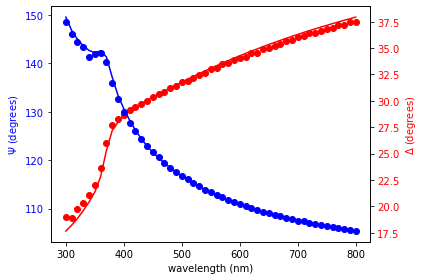

In [32]:
#print the MSE
print('MSE=',MSE(fitted_params))

# plot modeled and experimental delta
fig, ax1 = plt.subplots()

color = 'b'
ax1.set_xlabel('wavelength (nm)')
ax1.set_ylabel('$\Psi$ (degrees)', color=color)
ax1.plot(lambda_list,delta_mod, 'r-', raw_data.lambda_vac ,raw_data.delta_exp, 'ro')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'r'
ax2.set_ylabel('$\Delta$ (degrees)', color=color)  # we already handled the x-label with ax1
ax2.plot(lambda_list , psi_mod ,'b-', raw_data.lambda_vac , raw_data.psi_exp,'bo')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()